In [1]:
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import numpy as np
folder2 = "/data/PDGA_MAP4/"
folder1 = "/data/AIpep/"
from Levenshtein import distance as lev_dist
import os
import pickle
import random
from collections import Counter
from operator import itemgetter
import joblib
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from scipy.stats import rankdata
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolToSmiles, MolFromSmiles
from rdkit.Chem import Lipinski, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import tmap as tm
from faerun import Faerun
from map4 import MAP4Calculator
from tqdm.notebook import tqdm

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
MAP4 = MAP4Calculator(dimensions=1024)
def calc_map4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    mol = Chem.MolFromSmiles(smiles)
    map4 = MAP4.calculate(mol)
    return np.array(map4)

In [3]:
first_approach = pd.read_pickle(folder1+"pickles/gen_anticancer_with_NN_prop_helicity.pkl")
evaluation_1 = first_approach.query("isPredActive == True").copy()
filtered_1 = pd.read_csv("ML/data/anticancer_filtered.csv")
picked_1 = pd.read_csv("ML/data/anticancer_filtered_clustered.csv")

In [4]:
filtered_1["set"] = 0

In [5]:
second_approach = pd.read_pickle(folder2+"pickles/all_sequences_with_NN_prop_helicity-hem_correct_dist.pkl")
evaluation_2 = second_approach.query("isPredActive == True and isPredNotHemolytic == True").copy()
filtered_2 = pd.read_csv("PDGA&ML/data/pdga_filtered.csv")
picked_2 = pd.read_csv("PDGA&ML/data/pdga_filtered_clustered.csv")

In [6]:
filtered_2["set"] = 1

In [7]:
tl = pd.read_csv("ML/data/TL.csv")

In [8]:
tl["set"] = 2

In [9]:
df_all = pd.concat([filtered_1, filtered_2, tl])

In [10]:
df_all["MAP4"] = df_all.SMILES.parallel_map(calc_map4)

In [11]:
len(df_all.drop_duplicates("Sequence"))

407

In [12]:
len(df_all)

407

In [13]:
picked_1_seq = picked_1.Sequence.tolist()
picked_2_seq = picked_2.Sequence.tolist()

In [14]:
def is_picked(seq):
    if seq in picked_1_seq or seq in picked_2_seq:
        return 1
    else:
        return 0

In [15]:
def calc_mw(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mw = Descriptors.ExactMolWt(mol)
    return mw

In [16]:
def calc_pos(seq):
    seq = seq.upper()
    return (seq.count("K") + seq.count("R"))/len(seq)

def calc_neg(seq):
    seq = seq.upper()
    return (seq.count("D") + seq.count("E"))/len(seq)

def calc_hydr(seq):
    seq = seq.upper()
    return (seq.count("A") + seq.count("V") + seq.count("L") + seq.count("I") + seq.count("F") + seq.count("M") + seq.count("W") + seq.count("C"))/len(seq) 

def make_label(row):
    seq_ = row.seq
    if row.seq in picked_1_seq or row.seq in picked_2_seq:
        name = synth[synth["seq"] == seq_].id.to_list()[0]
        return f"{name}|{seq_}"
    else:
        return seq_

def calc_charge(row):
    return row.pos - row.neg
    
def charge_fraction(row):
    l = calc_all(row.seq)
    c = row.charge
    return c/l


def is_larger(seq):
    if seq == "ANWKKWIGKVIKLVK" or seq == "VNWKKILGKIIKVVK":
        print(seq)
        return 1
    else:
        return 0.5 

In [17]:
df_all["synth"] = df_all.Sequence.map(is_picked)

In [18]:
df_all["neg"]=df_all.Sequence.map(calc_neg)
df_all["pos"]=df_all.Sequence.map(calc_pos)
df_all["hydr"]=df_all.Sequence.map(calc_hydr)
df_all["islarger"]=df_all.Sequence.map(is_larger)

ANWKKWIGKVIKLVK
VNWKKILGKIIKVVK


In [19]:
if not os.path.exists(folder2+"all_anticancer_LSHforest_"):
    fps = df_all["MAP4"].tolist()
    fps_ = []

    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    lf = tm.LSHForest(1024, 32)
    lf.batch_add(fps_)

    lf.index()
    lf.store(folder2 + 'all_anticancer_LSHforest')
else:
    lf = tm.LSHForest(1024, 32)
    lf.restore(folder2 + 'all_anticancer_LSHforest')

In [20]:
df_all

,ID,Sequence,prediction,length,dist_Training,NN_Training,dist_Test,NN_Test,map_dist_Training,map_NN_Training,...,SS,countH,fraction_PredBetaSheet,fraction_PredCoil,HeLa,synth,neg,pos,hydr,islarger
0,gen_anticancer_91,LRFLGKVIKVLLKVL,0.998483,15,7,LKLLKKLLKKLLKLL,7,FLGALFKVASKVL,0.549805,FLGVLFKVLSKLL,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.266667,0.666667,0.5
1,gen_anticancer_318,KWWKKIKKLLRAFK,0.999596,14,6,IKKWWSKIKKLLK,6,KLWKKWKKWLK,0.473633,kFwKLLkKAlrLwKkVL,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.500000,0.500000,0.5
2,gen_anticancer_608,FFATIAKLLAGWFK,0.992423,14,6,FFPFVAKLLKGLF,7,FLPIIAKLLGGLL,0.583008,FFPIVAKLLRGLF,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.142857,0.714286,0.5
3,gen_anticancer_620,RWFKILKKIQRQW,0.996568,13,6,RWKIFKKVVKKW,6,RWKIFKKIEKVG,0.500977,RWFKIQLQIRRWKNKK,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.384615,0.461538,0.5
4,gen_anticancer_801,KWRKLLKRVARLVRA,0.997990,15,7,KWKIRVRLSA,7,KLKKLLKRWRRWWR,0.488281,KWRRKLKKLRPKKKRKV,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.466667,0.533333,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,10722,RLLRLLRLRRLLRL,0.918359,14,3,RLLRRLLRRLLR,0,RLLRLLRLRRLLRL,0.281250,LLRRLLRRLLRRLLRR,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",11.0,0.0,0.214286,True,0,0.0,0.428571,0.571429,0.5
49,10723,KLLKLLKKLLKLLK,0.948125,14,2,KLKKLLKKLKKLLK,0,KLLKLLKKLLKLLK,0.087891,KLKKLLKKLKKLLK,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",12.0,0.0,0.142857,True,0,0.0,0.428571,0.571429,0.5
50,12591,FKKLKKLFSKLWNWK,0.899559,15,2,FKRLKKLFSKIWNWK,0,FKKLKKLFSKLWNWK,0.224609,FKKLKKLFSKLKNWW,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",12.0,0.0,0.200000,True,0,0.0,0.400000,0.466667,0.5
51,12592,FKKLKKLFSKLWNWKRKKRRQRRR,0.524350,24,11,FKRLKKLFSKIWNWK,0,FKKLKKLFSKLWNWKRKKRRQRRR,0.529297,LKKLYKRLFKLWKRLYRYLKKPVR,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",22.0,0.0,0.083333,True,0,0.0,0.583333,0.291667,0.5


In [21]:
if not os.path.exists(folder2+"all_anticancer_tm_layout_.pkl"):
    cfg = tm.LayoutConfiguration()

    # config
    cfg.node_size = 1 / 35
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    # Compute the layout

    x_, y_, s, t, gp = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout, folder2+"all_anticancer_tm_layout.pkl")
else:
    tm_layout = joblib.load(folder2+"all_anticancer_tm_layout.pkl")

In [22]:
set_ = df_all.set.tolist()
labels = df_all.Sequence.tolist()
synth = df_all.synth.tolist()
lenght = df_all.length.tolist()
pos = df_all.pos.tolist()
neg = df_all.neg.tolist()
hydr = df_all.hydr.tolist()
size = df_all.islarger.tolist()

In [23]:
df_all

,ID,Sequence,prediction,length,dist_Training,NN_Training,dist_Test,NN_Test,map_dist_Training,map_NN_Training,...,SS,countH,fraction_PredBetaSheet,fraction_PredCoil,HeLa,synth,neg,pos,hydr,islarger
0,gen_anticancer_91,LRFLGKVIKVLLKVL,0.998483,15,7,LKLLKKLLKKLLKLL,7,FLGALFKVASKVL,0.549805,FLGVLFKVLSKLL,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.266667,0.666667,0.5
1,gen_anticancer_318,KWWKKIKKLLRAFK,0.999596,14,6,IKKWWSKIKKLLK,6,KLWKKWKKWLK,0.473633,kFwKLLkKAlrLwKkVL,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.500000,0.500000,0.5
2,gen_anticancer_608,FFATIAKLLAGWFK,0.992423,14,6,FFPFVAKLLKGLF,7,FLPIIAKLLGGLL,0.583008,FFPIVAKLLRGLF,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.142857,0.714286,0.5
3,gen_anticancer_620,RWFKILKKIQRQW,0.996568,13,6,RWKIFKKVVKKW,6,RWKIFKKIEKVG,0.500977,RWFKIQLQIRRWKNKK,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.384615,0.461538,0.5
4,gen_anticancer_801,KWRKLLKRVARLVRA,0.997990,15,7,KWKIRVRLSA,7,KLKKLLKRWRRWWR,0.488281,KWRRKLKKLRPKKKRKV,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.466667,0.533333,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,10722,RLLRLLRLRRLLRL,0.918359,14,3,RLLRRLLRRLLR,0,RLLRLLRLRRLLRL,0.281250,LLRRLLRRLLRRLLRR,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",11.0,0.0,0.214286,True,0,0.0,0.428571,0.571429,0.5
49,10723,KLLKLLKKLLKLLK,0.948125,14,2,KLKKLLKKLKKLLK,0,KLLKLLKKLLKLLK,0.087891,KLKKLLKKLKKLLK,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",12.0,0.0,0.142857,True,0,0.0,0.428571,0.571429,0.5
50,12591,FKKLKKLFSKLWNWK,0.899559,15,2,FKRLKKLFSKIWNWK,0,FKKLKKLFSKLWNWK,0.224609,FKKLKKLFSKLKNWW,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",12.0,0.0,0.200000,True,0,0.0,0.400000,0.466667,0.5
51,12592,FKKLKKLFSKLWNWKRKKRRQRRR,0.524350,24,11,FKRLKKLFSKIWNWK,0,FKKLKKLFSKLWNWKRKKRRQRRR,0.529297,LKKLYKRLFKLWKRLYRYLKKPVR,...,"['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', ...",22.0,0.0,0.083333,True,0,0.0,0.583333,0.291667,0.5


In [24]:
str(sns.color_palette("colorblind").as_hex())


"['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']"

In [25]:
sns.color_palette("colorblind").as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [26]:
from matplotlib.colors import ListedColormap
from faerun import Faerun

custom_cmap = ListedColormap([ "#cc78bc", "#029e73", "#d55e00"], name="custom")
custom_cmap2 = ListedColormap([ "#949494", "#d55e00"], name="custom2")

groups = ["0-First approach (202)", "1-Second approach (152)", "2-Fine-tuning set (53)"]
labels_groups, groups = Faerun.create_categories(groups)

groups2 = ["0-no", "1-yes"]
labels_groups2, groups2 = Faerun.create_categories(groups2)

In [27]:
faerun = Faerun(view="front", coords=False, title='MAP4_PDGA_anticancer', clear_color="#ffffff",)
faerun.add_scatter("MAP4_PDGA_anticancer",\
                   {"x": tm.VectorFloat(tm_layout["x"]), \
                        "y": tm.VectorFloat(tm_layout["y"]), \
                        "c": [lenght, pos, hydr, set_, synth],\
                        "labels": labels,
                   "s": size}, \
                    has_legend=True, \
                    colormap=["viridis","viridis", "viridis", custom_cmap, custom_cmap2], \
                    point_scale=15, \
                    categorical=[False, False, False, True, True],\
                    series_title=["sequence length", "fract. positive residues (K, R)", "fract. hydrophobic residues (A, V, L, I, F, M, W, C)", "set", "is synthesized"], \
                    max_legend_label=[str(round(max(lenght),2)), str(round(max(pos),2)), str(round(max(hydr),2)), None, None],\
                    min_legend_label=[str(round(min(lenght),2)), str(round(min(pos),2)), str(round(min(hydr),2)), None, None],\
                    legend_labels=[None, None, None, labels_groups, labels_groups2])

faerun.add_tree("MAP4_PDGA_anticancer_tree", {"from": tm.VectorUint(tm_layout["s"]), "to": tm.VectorUint(tm_layout["t"])}, point_helper="MAP4_PDGA_anticancer", color="aaaaaa")
faerun.plot('MAP4_PDGA_anticancer')

/home/alice/Code/Anticancers/MAP4_PDGA_anticancer.html

In [28]:
def distance(a, b):
    """Estimates the Jaccard distance of two binary arrays based on their hashes.

Arguments:
  a {numpy.ndarray} -- An array containing hash values.
  b {numpy.ndarray} -- An array containing hash values.

Returns:
  float -- The estimated Jaccard distance.
"""

    # The Jaccard distance of Minhashed values is estimated by
    return 1.0 - np.float(np.count_nonzero(a == b)) / np.float(len(a))

def find_map_seqNN(fp, dataframe):
    best_dist = float("inf")
    dists = dataframe["MAP4"].map(lambda fp2 : distance(fp,fp2))
    NNi = np.argmin(dists)
    best_dist = dists.iloc[NNi]
    NN = dataframe["Sequence"].iloc[NNi]
    return best_dist, NN

In [29]:
evaluation_1.columns

Index(['Sequence', 'Repetition', 'inTraining', 'Set', 'prediction',
       'isPredActive', 'ID', 'dist_Training', 'NN_Training', 'dist_Test',
       'NN_Test', 'SMILES', 'MAP4', 'length', 'D_AA', 'A_fract', 'C_fract',
       'D_fract', 'E_fract', 'F_fract', 'G_fract', 'H_fract', 'I_fract',
       'L_fract', 'M_fract', 'N_fract', 'P_fract', 'K_fract', 'Q_fract',
       'R_fract', 'S_fract', 'T_fract', 'V_fract', 'W_fract', 'Y_fract',
       'positive', 'negative', 'HAC', 'HBA', 'HBD', 'hydrophobic',
       'hydrophobic_patches', 'hydrophobic_patches_num',
       'hydrophobic_patches_len', 'hydro_res_fract', 'pos_res_fract',
       'HydroMoment', 'charge', 'hydrophobicity', 'av_hydrophobicity',
       'discrimination', 'fasta', 'SpiderFilename', 'SpiderFileloc',
       'map_dist_Training', 'map_NN_Training', 'map_dist_Test', 'map_NN_Test',
       'SS', 'countH', 'fraction_PredHelical', 'fraction_PredBetaSheet',
       'fraction_PredCoil'],
      dtype='object')

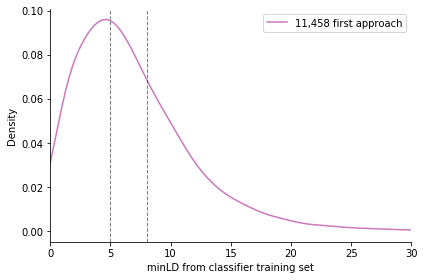

In [30]:
evaluation_1.dist_Training.plot.kde(label="11,458 first approach", c="#cc78bc")
plt.axvline(x=5, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.axvline(x=8, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("minLD from classifier training set")
plt.legend()
plt.xlim(0, 30)
sns.despine()
plt.tight_layout()
plt.savefig("plots/LD_traiing_1.svg")

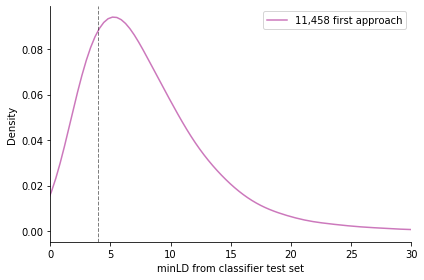

In [31]:
evaluation_1.dist_Test.plot.kde(label="11,458 first approach", c="#cc78bc")
plt.axvline(x=4, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("minLD from classifier test set")
plt.legend()
plt.xlim(0, 30)
sns.despine()
plt.tight_layout()
plt.savefig("plots/LD_test_1.svg")

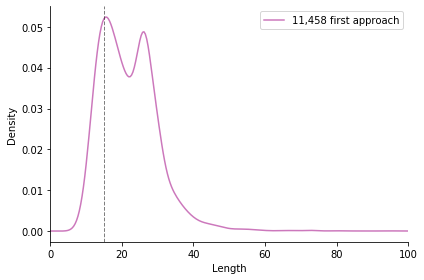

In [32]:
evaluation_1.length.plot.kde(label="11,458 first approach", c="#cc78bc")
plt.axvline(x=15, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Length")
plt.legend()
plt.xlim(0, 100)
sns.despine()
plt.tight_layout()
plt.savefig("plots/len_1.svg")

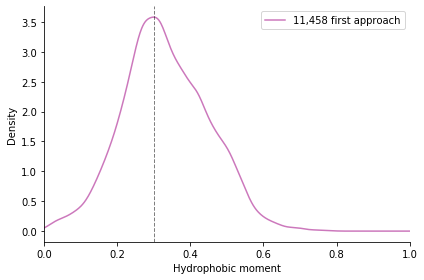

In [33]:
evaluation_1.HydroMoment.plot.kde(label="11,458 first approach", c="#cc78bc")
plt.axvline(x=0.3, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Hydrophobic moment")
plt.legend()
plt.xlim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("plots/hydr_mom_1.svg")

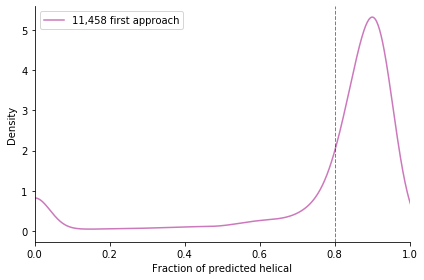

In [34]:
evaluation_1.fraction_PredHelical.plot.kde(label="11,458 first approach", c="#cc78bc")
plt.axvline(x=0.8, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Fraction of predicted helical")
plt.legend()
plt.xlim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("plots/frc_alpha_1.svg")

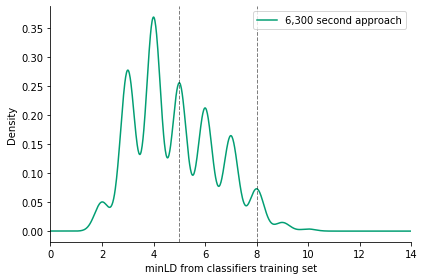

In [35]:
evaluation_2.dist_Training.plot.kde(label="6,300 second approach", c="#029e73")
plt.axvline(x=5, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.axvline(x=8, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("minLD from classifiers training set")
plt.legend()
plt.xlim(0, 14)
sns.despine()
plt.tight_layout()
plt.savefig("plots/ld_TRAINING_2.svg")

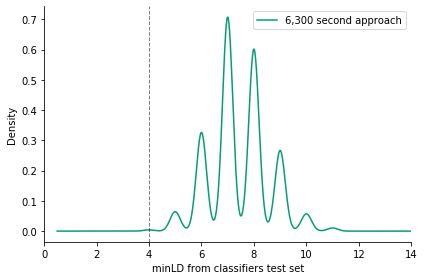

In [36]:
evaluation_2.dist_Test.plot.kde(label="6,300 second approach", c="#029e73")
plt.axvline(x=4, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("minLD from classifiers test set")
plt.legend()
plt.xlim(0, 14)
sns.despine()
plt.tight_layout()
plt.savefig("plots/LD_test_2.svg")

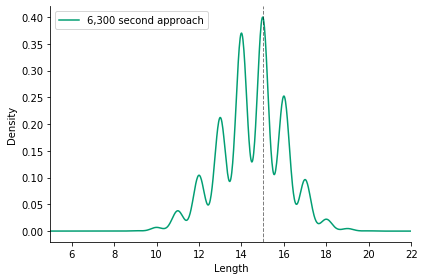

In [37]:
evaluation_2.length.plot.kde(label="6,300 second approach", c="#029e73")
plt.axvline(x=15, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Length")
plt.legend()
plt.xlim(5, 22)
sns.despine()
plt.tight_layout()
plt.savefig("plots/len_2.svg")

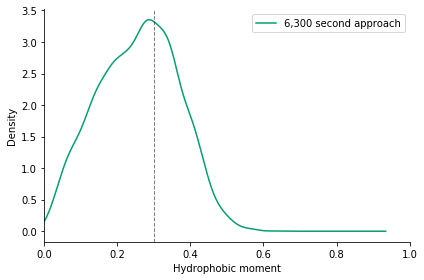

In [38]:
evaluation_2.HydroMoment.plot.kde(label="6,300 second approach", c="#029e73")
plt.axvline(x=0.3, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Hydrophobic moment")
plt.legend()
plt.xlim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("plots/hydro_mom_2.svg")

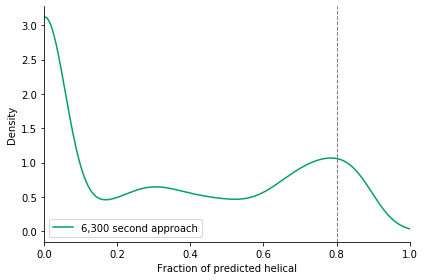

In [39]:
evaluation_2.fraction_PredHelical.plot.kde(label="6,300 second approach", c="#029e73")
plt.axvline(x=0.8, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Fraction of predicted helical")
plt.legend()
plt.xlim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("plots/frc_alpha_2.svg")

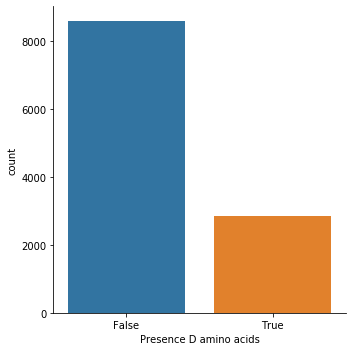

In [40]:
import seaborn as sns

g = sns.catplot(x="D_AA", kind="count", data=evaluation_1)
#g.set_xticklabels(rotation=90)

sns.despine()
plt.tight_layout()
plt.xlabel("Presence D amino acids")
plt.savefig("plots/daa_1.svg")